/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0519 - mae: 0.1669 - val_loss: 0.0112 - val_mae: 0.0817 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0125 - mae: 0.0870 - val_loss: 0.0108 - val_mae: 0.0818 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0123 - mae: 0.0872 - val_loss: 0.0106 - val_mae: 0.0800 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0120 - mae: 0.0871 - val_loss: 0.0110 - val_mae: 0.0808 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0117 - mae: 0.0847 - val_loss: 0.0131 - val_mae: 0.0918 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0124 - mae: 0.0877 - val_loss: 0.0102 - val_mae: 0.0786 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0110 - mae: 0.0819 - val_loss: 0.0121 - val_mae: 0.0856 - learning_rate: 0.0010
Epoch

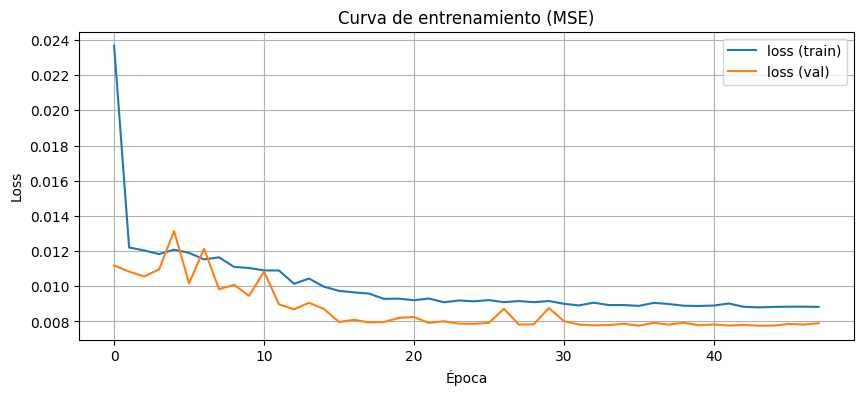

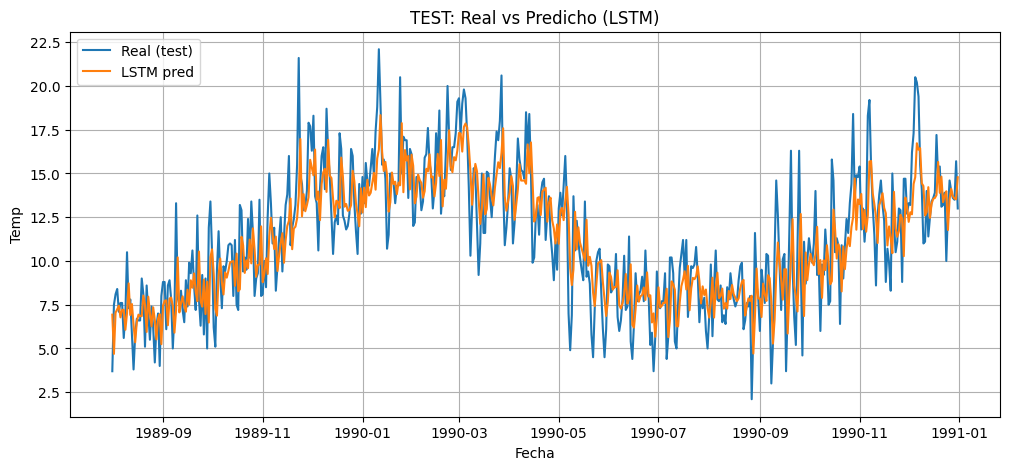

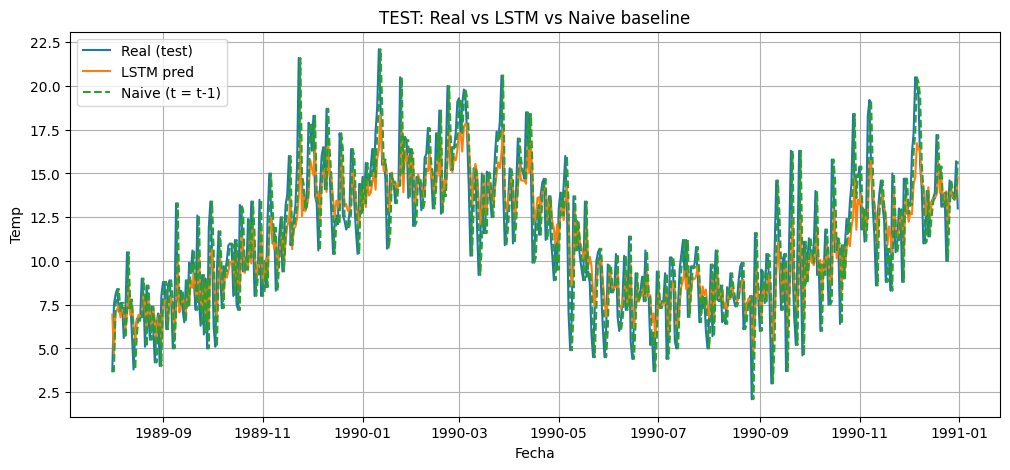


📌 Predicción para el siguiente día: 13.031118392944336

📌 Predicciones de los próximos días:
Día +1: 13.03
Día +2: 13.40
Día +3: 13.49
Día +4: 13.49
Día +5: 13.45
Día +6: 13.40
Día +7: 13.36

📌 Cobertura en TEST:
80% PI coverage: 79.9% (ideal ~80%)
95% PI coverage: 95.0% (ideal ~95%)


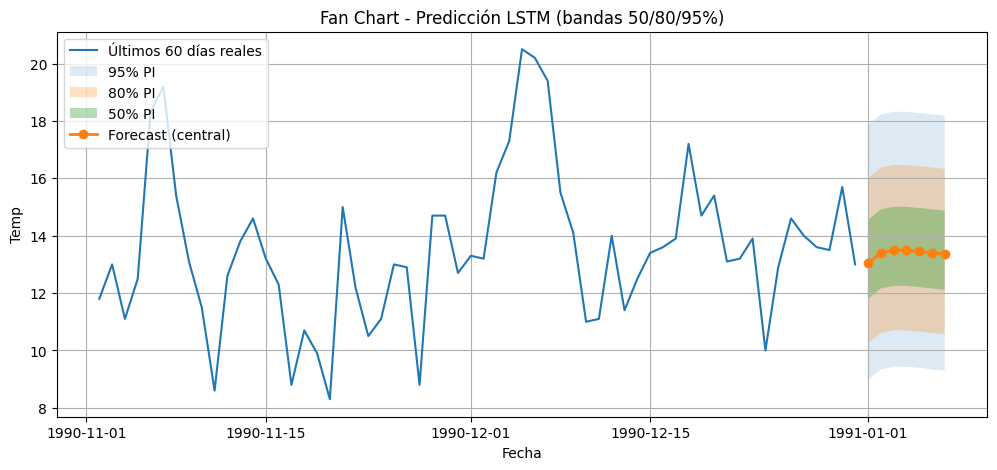


✅ Modelo guardado como: lstm_temperaturas_final.keras


In [ ]:
# ============================================================
# LSTM "PRO" para series de tiempo + métricas completas + Fan Chart
# Dataset: daily-min-temperatures (Jason Brownlee)
# Incluye:
# - Split temporal Train/Val/Test
# - Scaler fit SOLO en train (sin leakage)
# - LSTM 2 capas + Dropout
# - EarlyStopping + ReduceLROnPlateau + ModelCheckpoint
# - Métricas: MAE, RMSE, R², MAPE, sMAPE, Bias, MASE + baseline naive
# - Gráficos: curva loss, Real vs Pred, vs Naive
# - Pronóstico 1-step y multi-step
# - Fan chart (50/80/95%) por percentiles de residuos + cobertura en TEST
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# -----------------------------
# 1) Cargar datos
# -----------------------------
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=["Date"], index_col="Date")

data = df[["Temp"]].copy()  # (n,1) con índice de fechas


# -----------------------------
# 2) Split temporal: train/val/test
# -----------------------------
n = len(data)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = data.iloc[:train_end]
val_df   = data.iloc[train_end:val_end]
test_df  = data.iloc[val_end:]


# -----------------------------
# 3) Escalado (fit SOLO en train)
# -----------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df.values)
val_scaled   = scaler.transform(val_df.values)
test_scaled  = scaler.transform(test_df.values)


# -----------------------------
# 4) Crear secuencias
# -----------------------------
def crear_secuencias(arr_2d, pasos: int):
    """
    arr_2d: np.array 2D (n,1) ya escalado
    retorna:
      X: (n-pasos, pasos, 1)
      y: (n-pasos, 1)
    """
    X, y = [], []
    for i in range(pasos, len(arr_2d)):
        X.append(arr_2d[i - pasos:i, 0])
        y.append(arr_2d[i, 0])
    X = np.array(X).reshape(-1, pasos, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y


# Ajusta aquí: 7 suele ser poco; prueba 14/30/60 para mejorar
pasos = 30

X_train, y_train = crear_secuencias(train_scaled, pasos)
X_val,   y_val   = crear_secuencias(val_scaled, pasos)
X_test,  y_test  = crear_secuencias(test_scaled, pasos)


# -----------------------------
# 5) Modelo LSTM "más pro"
# -----------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(pasos, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
)

model.summary()


# -----------------------------
# 6) Callbacks
# -----------------------------
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=12,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=6,
    min_lr=1e-5
)

checkpoint = ModelCheckpoint(
    filepath="best_lstm_temperaturas.keras",
    monitor="val_loss",
    save_best_only=True
)


# -----------------------------
# 7) Entrenamiento
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

best_model = load_model("best_lstm_temperaturas.keras")


# -----------------------------
# 8) Predicción en TEST + desescalado
# -----------------------------
pred_test_scaled = best_model.predict(X_test, verbose=0)

pred_test = scaler.inverse_transform(pred_test_scaled)  # (n,1)
real_test = scaler.inverse_transform(y_test)            # (n,1)

real = real_test.reshape(-1)
pred = pred_test.reshape(-1)
errors = real - pred

mae  = mean_absolute_error(real, pred)
rmse = np.sqrt(mean_squared_error(real, pred))
r2   = r2_score(real, pred)

# MAPE y sMAPE
mape  = np.mean(np.abs(errors) / (np.abs(real) + 1e-8)) * 100
smape = 100 * np.mean(2 * np.abs(errors) / (np.abs(real) + np.abs(pred) + 1e-8))

bias = np.mean(errors)  # Mean Error (sesgo)

print("\n📊 Métricas en TEST (escala original):")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")
print(f"Bias (ME): {bias:.3f}  (positivo = real suele ser mayor que pred)")

# Baseline Naive (yhat_t = y_{t-1}) para comparar
naive = np.r_[real[0], real[:-1]]
naive_mae = np.mean(np.abs(real - naive))

mase = mae / (naive_mae + 1e-8)
print(f"Naive MAE (baseline): {naive_mae:.3f}")
print(f"MASE (vs naive): {mase:.3f}   (<1 => mejor que naive)")


# -----------------------------
# 9) Curvas de entrenamiento
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="loss (train)")
plt.plot(history.history["val_loss"], label="loss (val)")
plt.title("Curva de entrenamiento (MSE)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


# -----------------------------
# 10) Real vs Predicho en TEST (con fechas)
# -----------------------------
test_dates = test_df.index[pasos:]  # alinear con y_test/pred_test

plt.figure(figsize=(12, 5))
plt.plot(test_dates, real, label="Real (test)")
plt.plot(test_dates, pred, label="LSTM pred")
plt.title("TEST: Real vs Predicho (LSTM)")
plt.xlabel("Fecha")
plt.ylabel("Temp")
plt.grid(True)
plt.legend()
plt.show()

# Comparación contra baseline naive
plt.figure(figsize=(12, 5))
plt.plot(test_dates, real, label="Real (test)")
plt.plot(test_dates, pred, label="LSTM pred")
plt.plot(test_dates, naive, label="Naive (t = t-1)", linestyle="--")
plt.title("TEST: Real vs LSTM vs Naive baseline")
plt.xlabel("Fecha")
plt.ylabel("Temp")
plt.grid(True)
plt.legend()
plt.show()


# -----------------------------
# 11) Predicción 1 día adelante (t+1)
# -----------------------------
full_scaled = scaler.transform(data.values)
entrada = full_scaled[-pasos:].reshape(1, pasos, 1)

pred_next_scaled = best_model.predict(entrada, verbose=0)
pred_next = scaler.inverse_transform(pred_next_scaled)

print("\n📌 Predicción para el siguiente día:", float(pred_next[0][0]))


# -----------------------------
# 12) Predicción multi-step (próximos N días)
# -----------------------------
dias_a_predecir = 7
entrada = full_scaled[-pasos:].reshape(1, pasos, 1)

predicciones_futuras_scaled = []
for _ in range(dias_a_predecir):
    pred_step = best_model.predict(entrada, verbose=0)  # (1,1)
    pred_val = float(pred_step[0][0])
    predicciones_futuras_scaled.append(pred_val)

    # Desplazar ventana y agregar predicción
    entrada = np.concatenate([entrada[:, 1:, :], pred_step.reshape(1, 1, 1)], axis=1)

predicciones_futuras = scaler.inverse_transform(
    np.array(predicciones_futuras_scaled).reshape(-1, 1)
).reshape(-1)

print("\n📌 Predicciones de los próximos días:")
for i, p in enumerate(predicciones_futuras, 1):
    print(f"Día +{i}: {p:.2f}")


# -----------------------------
# 13) Fan Chart (50/80/95%) por percentiles de residuos
# -----------------------------
resid = errors  # (real - pred) en escala original

# Percentiles (aprox. bandas)
q50_lo, q50_hi = np.percentile(resid, [25, 75])     # ~50%
q80_lo, q80_hi = np.percentile(resid, [10, 90])     # ~80%
q95_lo, q95_hi = np.percentile(resid, [2.5, 97.5])  # ~95%

fc = predicciones_futuras  # forecast central

fc50_lo = fc + q50_lo
fc50_hi = fc + q50_hi
fc80_lo = fc + q80_lo
fc80_hi = fc + q80_hi
fc95_lo = fc + q95_lo
fc95_hi = fc + q95_hi

# Cobertura en TEST (calibración de intervalos)
test80_lo = pred + q80_lo
test80_hi = pred + q80_hi
test95_lo = pred + q95_lo
test95_hi = pred + q95_hi

coverage80 = np.mean((real >= test80_lo) & (real <= test80_hi)) * 100
coverage95 = np.mean((real >= test95_lo) & (real <= test95_hi)) * 100

print(f"\n📌 Cobertura en TEST:")
print(f"80% PI coverage: {coverage80:.1f}% (ideal ~80%)")
print(f"95% PI coverage: {coverage95:.1f}% (ideal ~95%)")


# Fechas futuras (asumiendo frecuencia diaria)
ultimos_n = 60
hist = data.iloc[-ultimos_n:].copy()

future_dates = pd.date_range(
    start=hist.index[-1] + pd.Timedelta(days=1),
    periods=dias_a_predecir,
    freq="D"
)

plt.figure(figsize=(12, 5))
plt.plot(hist.index, hist.values.reshape(-1), label=f"Últimos {ultimos_n} días reales")

# Bandas (fan chart)
plt.fill_between(future_dates, fc95_lo, fc95_hi, alpha=0.15, label="95% PI")
plt.fill_between(future_dates, fc80_lo, fc80_hi, alpha=0.25, label="80% PI")
plt.fill_between(future_dates, fc50_lo, fc50_hi, alpha=0.35, label="50% PI")

# Forecast central
plt.plot(future_dates, fc, marker="o", linewidth=2, label="Forecast (central)")

plt.title("Fan Chart - Predicción LSTM (bandas 50/80/95%)")
plt.xlabel("Fecha")
plt.ylabel("Temp")
plt.grid(True)
plt.legend()
plt.show()


# -----------------------------
# 14) Guardar modelo final (opcional)
# -----------------------------
best_model.save("lstm_temperaturas_final.keras")
print("\n✅ Modelo guardado como: lstm_temperaturas_final.keras")
